# H-R DIAGRAM
## Dimensionality reduction
We try to apply dimentionality reduction on a dataset reporting information about stars. First we get the dataset and the information that it contains:

In [1]:
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix
from tqdm import tqdm

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x7f99a1a77c50>)

In [3]:
stars = np.loadtxt("stars.csv", dtype=str, delimiter=',')
data = np.delete(stars, [0], axis=0)
names = np.delete(stars, range(1, len(stars[:, 0])), axis=0)
print(names)

[['Temperature (K)' 'Luminosity(L/Lo)' 'Radius(R/Ro)'
  'Absolute magnitude(Mv)' 'Star type' 'Star color' 'Spectral Class']]


We decide to work only on the real parameters:

In [4]:
data_real = np.array(np.delete(data, [4, 5, 6], axis=1), dtype = float)
star_type = [[i, np.unique(data[:, 4])[i]] for i in range(len(np.unique(data[:, 4])))]

The usual way these information are plotted is the H-R diagram: it plots the temperature versus the luminosity. In this case, we can also colour the differently the various types of stars:

[]

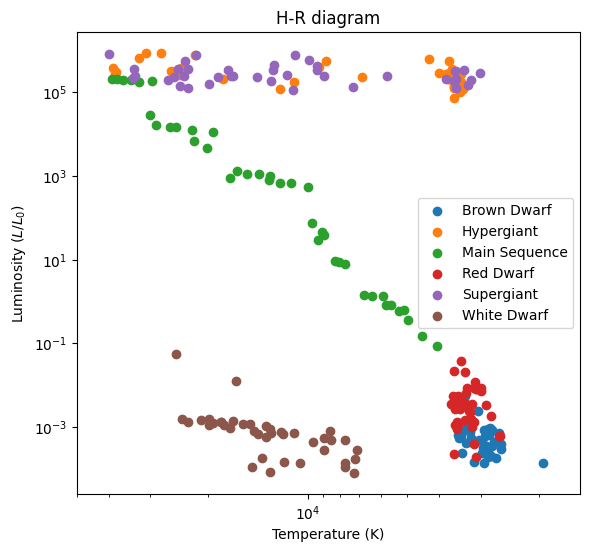

In [5]:
plt.figure(figsize = (6.5, 6))
for t in star_type:
    plt.scatter(data_real[data[:, 4] == t[1], 0], data_real[data[:, 4] == t[1], 1], label=t[1])

plt.xlim(5e4, 1.5e3)
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel(r"Luminosity ($L$/$L_0$)")
plt.title("H-R diagram")
plt.semilogx()
plt.semilogy()

We can see here that some of the groups of kind of stars mix into each other. If we would like to run a classification algorithm over this dataset, probably the performance in the calssification of such groups would be bad. So we run a PCA over the dataset to see if particular combinations of the features can make a better separation between the types of stars:

(-20000.0, 32000.0)

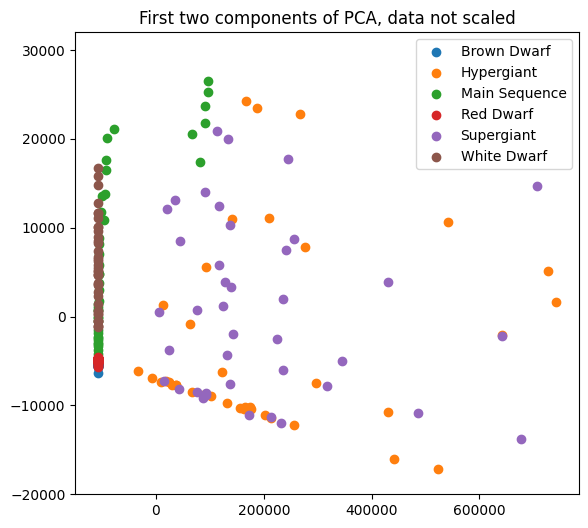

In [6]:
pca = PCA(n_components = 4)

pca.fit(data_real)
projected = pca.transform(data_real)

plt.figure(figsize = (6.5, 6))
for t in star_type:
    plt.scatter(projected[data[:, 4] == t[1], 0], projected[data[:, 4] == t[1], 1], label=t[1])
plt.title("First two components of PCA, data not scaled")
plt.legend()
plt.ylim(-20000, +32000)

We see that the performance is very poor. This is because the data are not appropriatly scaled. So we try two kind of scaling: the first is to scale the data in a way that all of them stay in the range $[-1, 1]$:

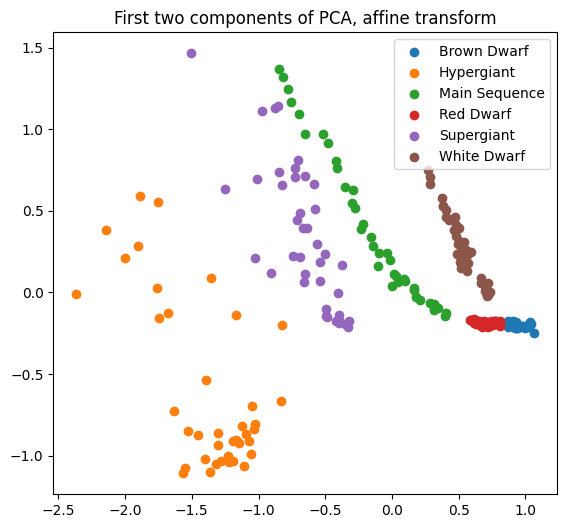

In [7]:
aff = MinMaxScaler(feature_range=(-1, 1))
aff.fit(data_real)
data_aff = aff.transform(data_real)

pca_aff = PCA(n_components = 4)
pca_aff.fit(data_aff)
projected_aff = pca_aff.transform(data_aff)

plt.figure(figsize = (6.5, 6))
for t in star_type:
    plt.scatter(projected_aff[data[:, 4] == t[1], 0], projected_aff[data[:, 4] == t[1], 1], label=t[1])
plt.title("First two components of PCA, affine transform")
plt.legend()

Here we plot the first two components of the data. And they seem to be enough to distinguish between the types of the stars! We can look at the variance explained by the components:

Text(0.5, 1.0, 'Cumulative variance explained by component')

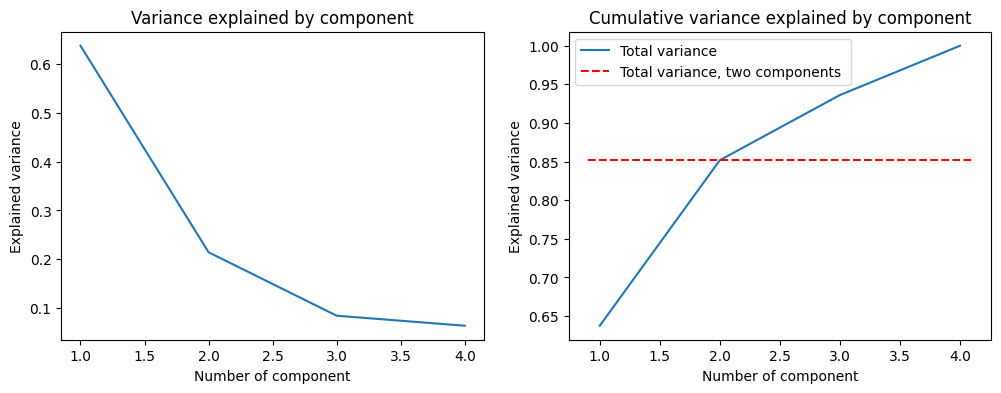

In [8]:
exp_var = pca_aff.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(exp_var) + 1), exp_var)
plt.xlabel("Number of component")
plt.ylabel("Explained variance")
plt.title("Variance explained by component")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(exp_var) + 1), cum_var, label = "Total variance")
xgrid = np.linspace(0.9, 4.1, 1000)
ygrid = np.full(1000, cum_var[1])
plt.plot(xgrid, ygrid, ls = '--', c = 'red', label="Total variance, two components ")
plt.legend()
plt.xlabel("Number of component")
plt.ylabel("Explained variance")
plt.title("Cumulative variance explained by component")

In [9]:
print("Total variance explained with two components: {:.3f} %".format(cum_var[1] * 100))

Total variance explained with two components: 85.185 %


Now we do the same thing but rescaling the data in a way such that every feature has separately mean zero and variance one:

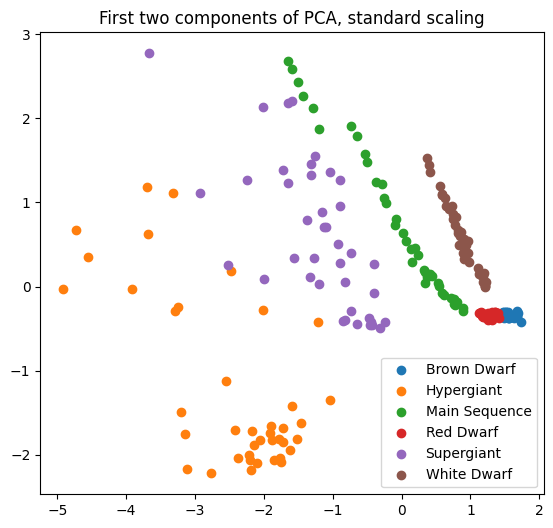

In [10]:
sc = StandardScaler()
sc.fit(data_real)
data_sc = sc.transform(data_real)

pca_sc = PCA(n_components = 4)
pca_sc.fit(data_sc)
projected_sc = pca_sc.transform(data_sc)

plt.figure(figsize = (6.5, 6))
for t in star_type:
    plt.scatter(projected_sc[data[:, 4] == t[1], 0], projected_sc[data[:, 4] == t[1], 1], label=t[1])
plt.title("First two components of PCA, standard scaling")
plt.legend()

In this case the performance is quite similar to the affine tranformation. Let's look at the explained variance:

Text(0.5, 1.0, 'Cumulative variance explained by component')

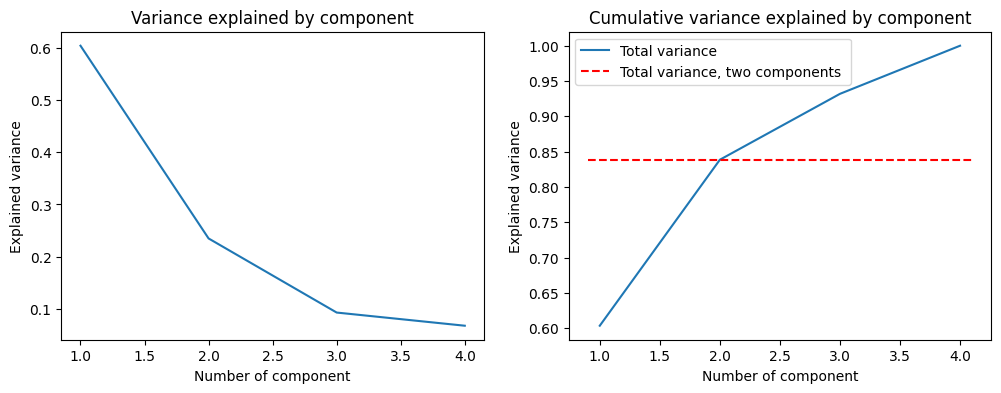

In [11]:
exp_var = pca_sc.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(exp_var) + 1), exp_var)
plt.xlabel("Number of component")
plt.ylabel("Explained variance")
plt.title("Variance explained by component")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(exp_var) + 1), cum_var, label = "Total variance")
xgrid = np.linspace(0.9, 4.1, 1000)
ygrid = np.full(1000, cum_var[1])
plt.plot(xgrid, ygrid, ls = '--', c = 'red', label="Total variance, two components ")
plt.legend()
plt.xlabel("Number of component")
plt.ylabel("Explained variance")
plt.title("Cumulative variance explained by component")

In [12]:
print("Total variance explained with two components: {:.3f} %".format(cum_var[1] * 100))

Total variance explained with two components: 83.858 %


We see here that the explained variance is slightly less than what the PCA with an affine transformation of the data can do.
## Classification
We now want to build a classifier. We'll use the Random Forest algorithm. We cross-validate the depth wit a 10-fold validation:

In [13]:
y = np.array([])
for i in range(len(data[:, 0])):
    for t in star_type:
        if data[i][4] == t[1]:
            y = np.append(y, t[0])

X = projected_sc[:, :2]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

dim_sample = len(data[:, 0])
rng = np.random.default_rng(seed=130301)
indices = np.arange(dim_sample)
rng.shuffle(indices)

K = 10
depth_max = 20
train_len = int(dim_sample - dim_sample / K)
val_len = int(dim_sample / K)
acc_tr = np.zeros(K)
acc_te = np.zeros(K)
acc_tr_model = np.zeros(depth_max)
acc_te_model = np.zeros(depth_max)
for d in tqdm(range(1, depth_max + 1)):
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : dim_sample])
        clf = RandomForestClassifier(n_estimators=10, max_depth=d, n_jobs=-1)
        clf.fit(X[train_data], y[train_data])
        y_test_pred = clf.predict(X[test_data])
        y_train_pred = clf.predict(X[train_data])
        acc_tr[i-1] = accuracy_score(y[train_data], y_train_pred)
        acc_te[i-1] = accuracy_score(y[test_data], y_test_pred)
    acc_tr_model[d-1], acc_te_model[d-1] = np.mean(acc_tr), np.mean(acc_te)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]


Text(0, 0.5, 'Accuracy')

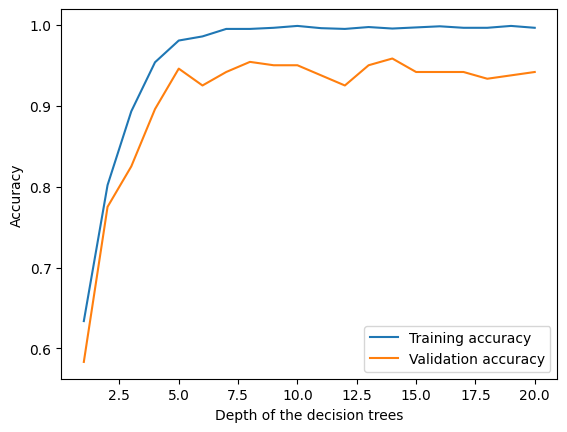

In [14]:
plt.plot(range(1, depth_max+1), acc_tr_model, label = "Training accuracy")
plt.plot(range(1, depth_max+1), acc_te_model, label = "Validation accuracy")
plt.legend()
plt.xlabel("Depth of the decision trees")
plt.ylabel("Accuracy")

Seven seems to be the depth at wich the validation accuracy reach a plateau. We can print the accuracy and the confution matrix:

Best accuracy: 94.17%
Confution matrix:
[[14  0  0  0  0  0]
 [ 0 13  0  0  0  0]
 [ 1  0  7  0  2  0]
 [ 0  0  0 10  0  0]
 [ 0  0  1  0  9  0]
 [ 0  0  0  0  0 15]]
Star type: 0; Star type number: Brown Dwarf
Star type: 1; Star type number: Hypergiant
Star type: 2; Star type number: Main Sequence
Star type: 3; Star type number: Red Dwarf
Star type: 4; Star type number: Supergiant
Star type: 5; Star type number: White Dwarf


/tmp/ipykernel_81714/655800378.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(confusion_matrix(y_test, y_test_pred)),


Text(0.5, 0, 'predicted')

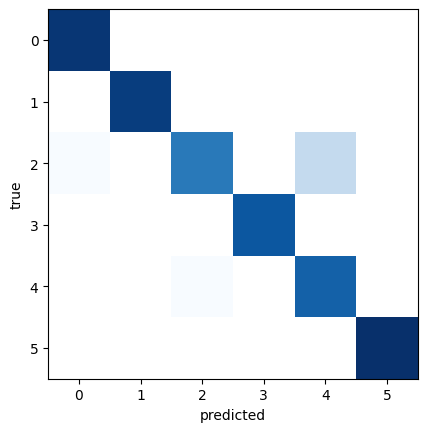

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
clf = RandomForestClassifier(n_estimators=10, max_depth=np.argmax(acc_te_model), n_jobs=-1)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print("Best accuracy: {:.2f}%".format((acc_te_model[6]) * 100))
print("Confution matrix:")
print(confusion_matrix(y_test, y_test_pred))
for t in star_type:
    print("Star type: {}; Star type number: ".format(t[0]) + t[1])
plt.imshow(np.log(confusion_matrix(y_test, y_test_pred)), 
           cmap='Blues', interpolation='nearest');
plt.ylabel('true')
plt.xlabel('predicted')